# Market Response Model & Uplift Modelling

In this project I wanted to explore how to build a Market Response Model and go a little bit further and also build an Uplift Model.




## Plan of the project:


### Market Response Model

1. Inspecting the data to gain insights 

2. Building the Uplift function to measure the market response to different campaigns

3. Comparing each feature separately to gain more insights on their importance and impact on conversion

4. Building ML model for scoring the conversion probability of all customers

5. Applying the best model to the dataset

### Uplift Modelling

1. Assigning customers to four target classes and getting probabilities of being in each of them for all customers

2. Calculating uplift score for each customer

3. Evaluating the model 


# Market Response Model

Market response models are intended to help managers understand how consumers individually and collectively respond to marketing activities.

In this particular dataset, we have two marketing activities to measure to help improve decision making process and budget distribution. These activities are two different offers that were sent to company customers. 

We also have a control group (customers who didn't receive any offer), so we can build the response model based on individual level. The assumption is that giving an offer should increase the probability of conversion. The uptick in the individuals’ conversion probability will bring us the incremental conversion.

In this project I want to answer the following questions:

1. Does giving an offer increase conversion?
2. If yes, what kind of offer performs best? Discount or Buy One Get One?
3. What feature is the most important in term of conversion?
4. How can Uplift Modeling improve marketing campaign performance?



In [702]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split



#function for ordering cluster numbers for given criteria
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

##  1. Inspecting the data to gain insights

In [703]:
data = pd.read_csv('data.csv')
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


We can see that this dataset consists of 9 columns, which are:
1. recency - months since last purchase

2. history - $value of the historical purchases

3. used_discount - indicates if the customer used a discount before

4. used_bogo - indicates if the customer used a buy one get one before

5. zip_code - class of the zip code as Suburban/Urban/Rural

6. is_referral - indicates if the customer was acquired from referral channel

7. channel - channels that the customer using, Phone/Web/Multichannel

8. offer - the offers sent to the customers, Discount/But One Get One/No Offer

9. conversion - customer conversion(buy or not)

In [704]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


There are  6,400 entries of customers data

In [705]:
data.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


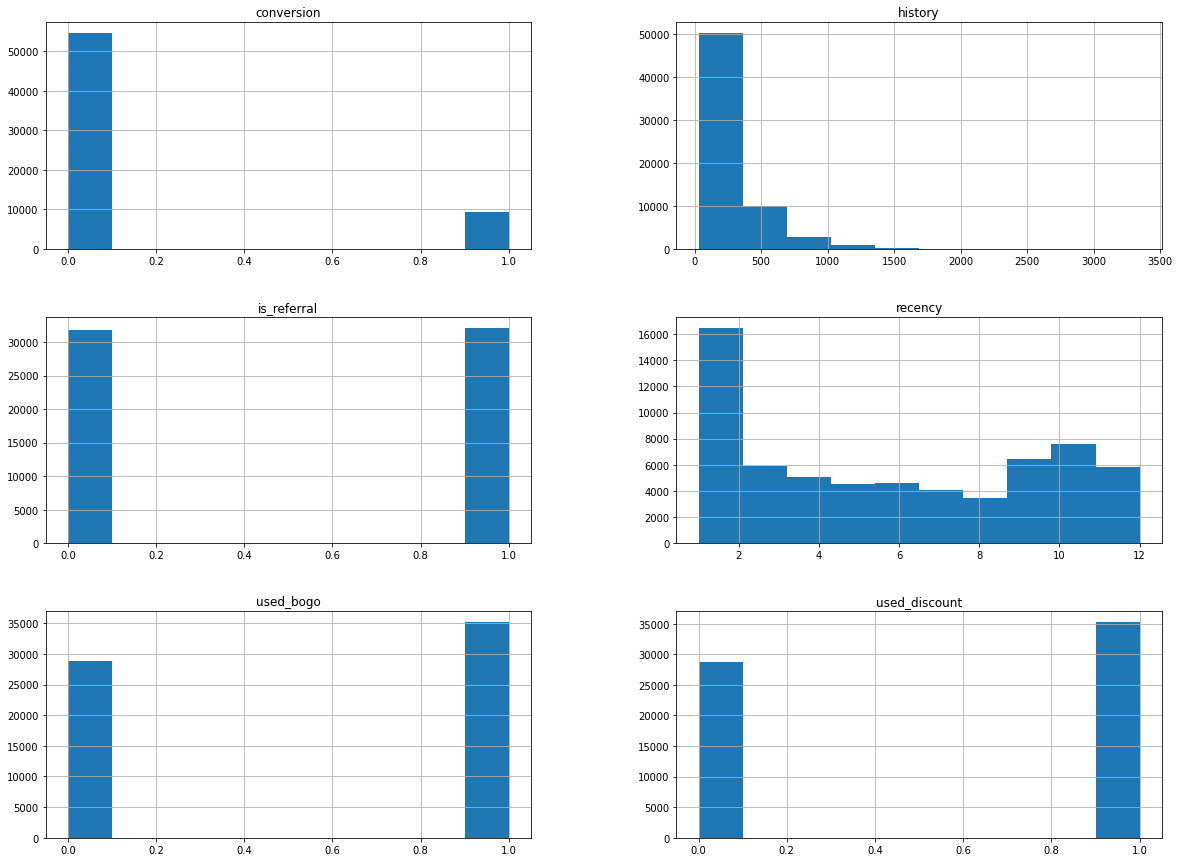

In [706]:

data.hist(figsize=(20,15))
plt.show()


From this quick visualisation we can see that most of the customers do not make a purchase, only 14% do. Most of the purchases occur during the first two months with the average value of the historical purchases of $242. 

## 2. Building the Uplift function to measure the market response to different campaigns

We will assume every conversion means 1 order and the average order value is $25.

We are going to calculate three types of uplift:

* Conversion Uplift: Conversion rate of test group - conversion rate of control group

* Order Uplift: Conversion uplift * converted customer in test group

* Revenue Uplift: Order Uplift * Average order $ value



In [707]:
def calc_uplift(df):
    #assigning 25$ to the average order value
    avg_order_value = 25
    
    
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
          
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:  
        
        print('-------------- \n')
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))

In [708]:
calc_uplift(data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Customers who received a discount offer appeared to be more responsive, its discount conversion uplift is 3.14% higher than BOGO. For 21307 customers who were sent a discount, the Revenue Uplift per customer is \\$1.90 compared to $1.10 of BOGO offer. 

## 3. Comparing each feature separately to gain more insights on their importance and impact on conversion

For each column, I want to first find out how it impacted conversion and second have a look at how the data in these columns is distributed among all the customers who made a purchase.

In [709]:
# Selecting rows with conversion
conversion_channels = data[data.conversion == 1] 

###  Zip code

The Rural group shows better conversion compared to others despite the fact most of the purchases were made by the Suburban group. The second can be explained by a lower number of customers representing the Rural class in the given dataset compared to the two others. 

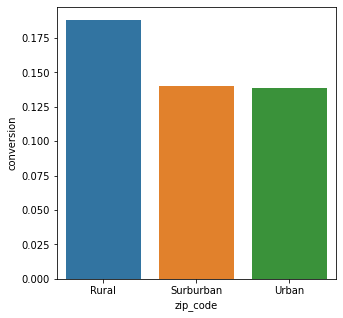

In [710]:
import seaborn as sns
df_plot = data.groupby('zip_code').conversion.mean().reset_index()

sns.barplot(data = df_plot, x
= "zip_code", y = "conversion")

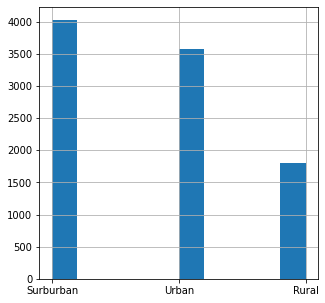

In [711]:
conversion_channels['zip_code'].hist()
plt.show()

## Channels

Although Multichannel shows the highest conversion rate, Web channel shows the highest amount of purchases.

In [573]:
conversion_channels['channel'].value_counts()

Web             4498
Phone           3563
Multichannel    1333
Name: channel, dtype: int64

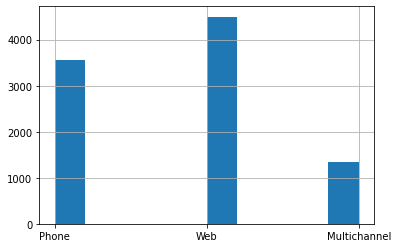

In [574]:
conversion_channels['channel'].hist()
plt.show()

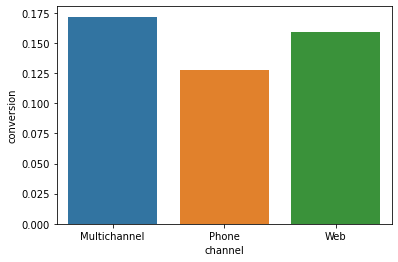

In [575]:
df_plot = data.groupby('channel').conversion.mean().reset_index()

sns.barplot(data = df_plot, x
= "channel", y = "conversion")

## Offer

Discount offer shows better conversion, approximately 18% compared to 15% of Buy One Get One offer. Customers without any offer reach only a 10% conversion rate. 

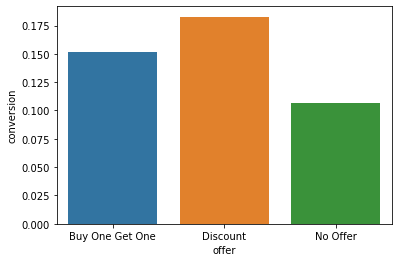

In [576]:
df_plot = data.groupby('offer').conversion.mean().reset_index()

sns.barplot(data = df_plot, x
= "offer", y = "conversion")

In [577]:
conversion_channels['offer'].value_counts()


Discount           3894
Buy One Get One    3238
No Offer           2262
Name: offer, dtype: int64

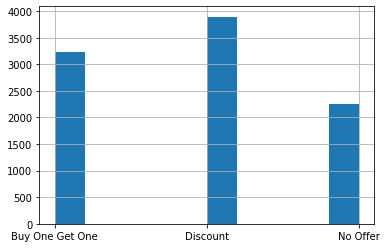

In [578]:
conversion_channels['offer'].hist()
plt.show()

## History

In order to get insights from the column, it must be divided into clusters with different value of the historical purchases. To do so let's use unsupervised ML algorithm - KMeans and the function written in the beginning of the project.  I divided the customers data into 15 clusters to get a more precise understanding of the distribution of the data.  

In [714]:
kmeans = KMeans(n_clusters=15)
kmeans.fit(data[['history']])
data['history_cluster'] = kmeans.predict(data[['history']])

#order the cluster numbers 
data = order_cluster('history_cluster', 'history', data, True)


In [715]:
#print the clusters 
data.groupby('history_cluster').agg({'history':['mean','min','max'], 'conversion':['count', 'mean']})

history                   conversion          
                        mean      min      max      count      mean
history_cluster                                                    
0                  38.455717    29.99    64.57      15978  0.122669
1                  90.762923    64.58   119.75      10318  0.125606
2                 148.902153   119.76   180.71       8598  0.127123
3                 212.758295   180.72   249.18       7302  0.149000
4                 285.887785   249.19   326.12       5833  0.177267
5                 366.621041   326.14   413.34       4640  0.182543
6                 460.210005   413.38   513.07       3663  0.186186
7                 565.951715   513.15   625.65       2676  0.157324
8                 685.127149   625.74   754.01       1873  0.179925
9                 822.707065   754.17   908.07       1339  0.194922
10                993.629459   908.64  1101.04        832  0.207933
11               1209.114511  1101.31  1343.18        532  0.206767
12               1481.191272  1344.11  1673.89        283  0.236749
13               1874.596667  1674.63  2239.16        114  0.192982
14               2742.320526  2319.40  3345.93         19  0.157895

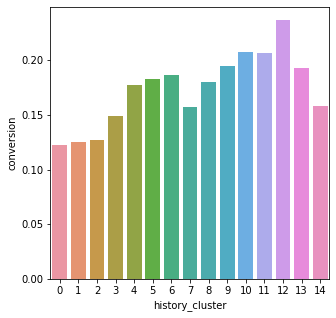

In [716]:
df_plot = data.groupby('history_cluster').conversion.mean().reset_index()

sns.barplot(data = df_plot, x
= "history_cluster", y = "conversion")

As we can see conversion rates increase with the increase of the value of the historical purchases until it hits the amount of $1495. With higher value conversion rates dramatically decrease by approximately 9%.

## Recency

Conversion decreases during the first 10 months since last purchase from 19% to 12%. Then it increases. We can also see that from 9 to 10th months the amount of purchases is approximately equal to the 4th month. It can be due to many reasons one of which could be the effect of the given offers.

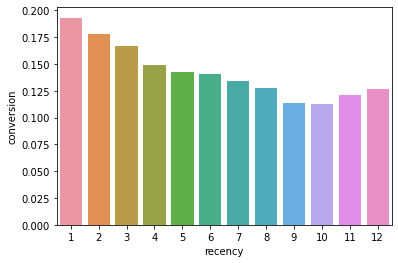

In [585]:
df_plot = data.groupby('recency').conversion.mean().reset_index()

sns.barplot(data = df_plot, x
= "recency", y = "conversion")

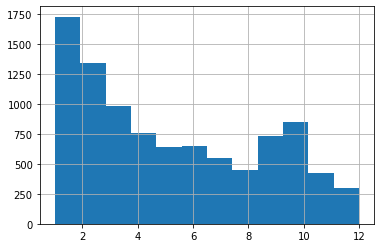

In [586]:
conversion_channels['recency'].hist(bins = 12)
plt.show()

In [587]:
conversion_channels['recency'].value_counts()


1     1728
2     1340
3      982
10     852
4      756
9      734
6      648
5      642
7      546
8      447
11     423
12     296
Name: recency, dtype: int64

## Referral 

Conversion rates drop by 5% if the customer was acquired from referral channel


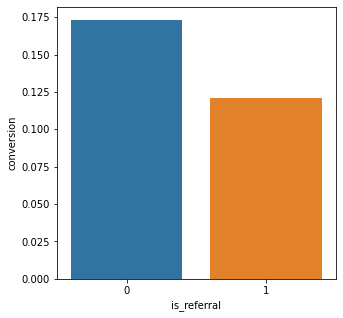

In [717]:
df_plot = data.groupby('is_referral').conversion.mean().reset_index()

sns.barplot(data = df_plot, x
= "is_referral", y = "conversion")

# 4. Building ML model for scoring the conversion probability of all customers

## Preparing the Data for Machine Learning Algorithms

Let’s separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that `drop()` creates a copy of the data and does not affect the original dataset):

In [718]:
data = data.drop('history_cluster', axis= 1)

In [719]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
3,6,139.87,0,1,Rural,1,Web,Discount,0
4,6,162.98,0,1,Surburban,0,Web,Discount,0


Next, we need to deal with categorical data, such as zip_code, channel and offer. We will be working with XGBoost ML algorithm and the easiest way to transform categorical data into numeric data for this model is to get dummies.

In [720]:
data_transf = pd.get_dummies(data)

In [721]:
#create feature set and labels
X = data_transf.drop(['conversion'],axis=1)
y = data_transf.conversion

In [722]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state = 100)

## XGBoost

In [723]:
X_train = X_train
y_train = y_train
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [724]:
n_scores = cross_val_score(xgb_model, X_train, y_train, scoring='accuracy')
print('Accuracy: {}, std: {}'.format(round(n_scores.mean(), 4), round(n_scores.std(), 4)))

Accuracy: 0.8502, std: 0.0007


In [725]:
xgb_predictions = xgb_model.predict(X_test) 
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10975
           1       0.31      0.01      0.01      1825

    accuracy                           0.86     12800
   macro avg       0.58      0.50      0.47     12800
weighted avg       0.78      0.86      0.79     12800



This model works very well, it shows 85% accuracy with only 0.05% std. It does not predict 1-values great, which was expected since most of the training data are zeros. 

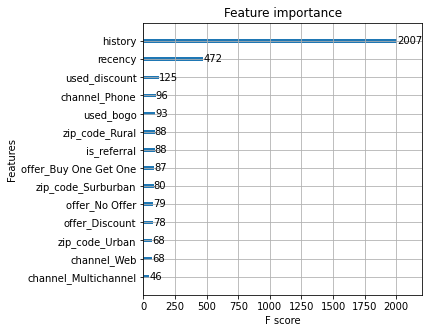

In [726]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [5, 5]

## Decision tree

In [727]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [605]:
n_scores = cross_val_score(tree, X_train, y_train, scoring='accuracy')
print('Accuracy: {}, std: {}'.format(round(n_scores.mean(), 4), round(n_scores.std(), 4)))

Accuracy: 0.7571, std: 0.0029


In [606]:
tree_predictions = tree.predict(X_test) 
print(classification_report(y_test, tree_predictions))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     10958
           1       0.18      0.17      0.17      1842

    accuracy                           0.76     12800
   macro avg       0.52      0.52      0.52     12800
weighted avg       0.76      0.76      0.76     12800



Decision tree model's accuracy is 76% which is 9% less than the XGBoost, although its predictions of 1-values are better.  

## Logistic regression

Let's try a classic binary ML model - Logistic Regression. For this model data needs to be scaled. I created a pipeline in case I would need to add mode transformations.

In [729]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
X_train= num_pipeline.fit_transform(X_train)

In [730]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [731]:
n_scores = cross_val_score(log_reg, X_train, y_train, scoring='accuracy')
print('Accuracy: {},  std: {}'.format(round(n_scores.mean(), 4), round(n_scores.std(), 4)))

Accuracy: 0.8521,  std: 0.0002


In [733]:
log_predictions = log_reg.predict(X_test) 
print(classification_report(y_test, log_predictions))

              precision    recall  f1-score   support

           0       0.90      0.05      0.10     10975
           1       0.14      0.96      0.25      1825

    accuracy                           0.18     12800
   macro avg       0.52      0.51      0.18     12800
weighted avg       0.79      0.18      0.12     12800



Although the cross-validation score shows 85% accuracy, the classification_report is not so happy with this models performance. Therefore we will continue working with the XGBoost classifier.  

# 5. Testing the best model

In [735]:
#You can run this line in case you need to run the line below twice and you get an error
#X_test = X_test.drop('proba', axis = 1)


We are going to create a column 'proba' which contains the probabilities of conversion for all customers and also add 'conversion' column back to the `X_test` set as it was dropped earlier

In [736]:
X_test['proba'] = xgb_model.predict_proba(X_test)[:,1]


In [646]:
#X_test = X_test.drop('conv', axis = 1)

In [737]:
X_test['conv'] = y_test

In [738]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,proba,conv
8266,10,165.83,1,0,0,0,1,0,0,0,1,0,0,1,0.058437,0
6425,9,179.87,1,0,1,0,1,0,0,1,0,0,0,1,0.021241,0
12330,7,349.69,0,1,0,1,0,0,0,1,0,1,0,0,0.174239,0
37145,1,525.38,0,1,1,0,1,0,0,1,0,0,0,1,0.090436,0
9257,1,360.75,1,0,1,0,1,0,0,0,1,1,0,0,0.140275,1


To measure the performance of our predictions we are going to calculate the real uplift for Discount and BOGO separately and do the same with the predictions. The results should be more or less the same if our model performs well. 

In [739]:
real_disc_upstick = len(X_test)*(X_test[X_test['offer_Discount'] == 1].conv.mean() - X_test[X_test['offer_No Offer'] == 1].conv.mean())

pred_disc_upstick = len(X_test)*(X_test[X_test['offer_Discount'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean())

In [631]:
print('Real Discount Upstick per order: {}, Revenue: {}'.format(round(real_disc_uptick), round(real_disc_uptick * 25)))
print('Predicted Discount Upstick per order: {}, Revenue: {}'.format(round(pred_disc_uptick), round(pred_disc_uptick * 25)))

Real Discount Uplift per order: 1006, Revenue: 25156
Predicted Discount Uplift per order: 1011, Revenue: 25266


The results are great, as we can see the predicted discount uplift per order is only 0.5% higher than the real one and predicted revenue uplift is also only 0.4% higher. 

Now let's do the same calculations for BOGO

In [740]:
real_bogo_upstick = len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].conv.mean() - X_test[X_test['offer_No Offer'] == 1].conv.mean())
pred_bogo_upstick = len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean())

In [741]:
print('Real BOGO Upstick per order: {}, Revenue: {}'.format(round(real_bogo_uptick), round(real_bogo_uptick * 25)))
print('Predicted BOGO Upstick per order: {}, Revenue: {}'.format(round(pred_bogo_uptick), round(pred_bogo_uptick * 25)))

Real BOGO Upstick per order: 507, Revenue: 12685
Predicted BOGO Upstick per order: 609, Revenue: 15221


Well, our model appeared to be less effective for BOGO offer, the difference in predicted and real values is 20%. This is not great, but it can be explained by not an equal distribution of labels in the training dataset. However, we are not going to spend more time trying to fix this because in our case we decided that discount treatment was more efficient and we will move forward with it. 

# Uplift modelling


Uplift modelling is a methodology that predicts the influence of a marketing treatment on a customer’s purchase behaviour. The objective is to target users who are likely to buy when given a treatment but are unlikely to buy otherwise. Thus, we need to predict the buying behaviour of customers when they are given the treatment, and when they are not. Therefore we are going to assign each customer from the dataset to one of the target groups:

* Treatment Responders: Customers that will purchase only if they receive an offer

* Treatment Non-Responders: Customer that won’t purchase in any case
* Control Responders: Customers that will purchase without an offer
* Control Non-Responders: Customers that will not purchase if they don’t receive an offer


The objective of this modelling is targetting Treatment Responders (TR) and Control Non-Responders (CN). On the other hand, we need to avoid targeting Treatment Non-Responders (TN) and Control Responders (CR) because its cost will be bigger than the revenue. Let's dig into it and see how it goes step by step.

## 1. Assigning customers to four target classes and getting probabilities of being in each of them for all customers

First let's build a function that will assign each customer from the dataset to one of the target groups and add the results to a new column 'target' in our dataset.

In [657]:
target = []
for index, row in data.iterrows():
    if (row['offer'] != "No Offer") & (row['conversion'] == 1):
        # TR group
        target.append(0)
    elif (row['offer'] == "No Offer") & (row['conversion'] == 1):
        # CR group
        target.append(1)
    elif (row['offer'] != "No Offer") & (row['conversion'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)
data['target'] = target

In [658]:
data['target'].value_counts()

2    35562
3    19044
0     7132
1     2262
Name: target, dtype: int64

In [659]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,2
1,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,0
2,6,139.87,0,1,Rural,1,Web,Discount,0,2
3,6,162.98,0,1,Surburban,0,Web,Discount,0,2
4,6,128.01,0,1,Urban,0,Web,Discount,0,2


I'm going to add again history clusters to our dataset as I dropped this column earlier, but it might help the multiclassification model make better predictions. 

In [660]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(data[['history']])
data['history_cluster'] = kmeans.predict(data[['history']])

#order the clusters
data = order_cluster('history_cluster', 'history', data,True)


Now we need to drop columns that define the labels ('target' column) and get dummies again for the categorical data

In [662]:
#creating a new dataframe as model and dropping columns that define the labels
data_model = data.drop(['offer','conversion'],axis=1)

In [663]:

data_model = pd.get_dummies(data_model)

Let’s fit our model and get the probabilities for each class:

In [667]:
#create feature set and labels
X = data_model.drop(['target'],axis=1)
y = data_model['target']

#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)


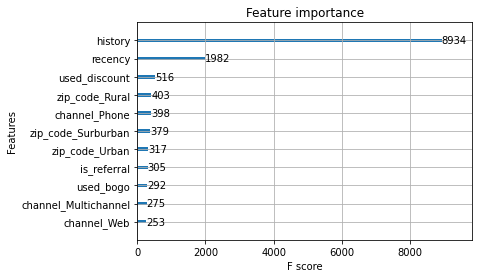

In [694]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [5, 5]

In [668]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(data_model.drop(['target'],axis=1))

## 2. Calculating uplift score for each customer

In [669]:
#assign probabilities to 4 different columns
data_model['proba_CN'] = overall_proba[:,0] 
data_model['proba_CR'] = overall_proba[:,1] 
data_model['proba_TN'] = overall_proba[:,2] 
data_model['proba_TR'] = overall_proba[:,3]

Now that we have the probabilities for each customer to be in each group we need to calculate UPLIFT SCORE for each of them. Uplift score can be found by this formula:

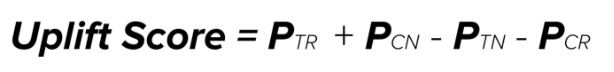



In [670]:
#calculate uplift score for all customers
data_model['uplift_score'] = data_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

#assign it back to main dataframe
data['uplift_score'] = data_model['uplift_score']

In [671]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,target,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,2,0,-0.150011
1,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,0,0,-0.125678
2,6,139.87,0,1,Rural,1,Web,Discount,0,2,0,-0.209330
3,6,128.01,0,1,Urban,0,Web,Discount,0,2,0,-0.204689
4,3,134.59,1,0,Urban,1,Phone,Buy One Get One,1,0,0,-0.095865


## 3. Model Evaluation

Perfect, we have an uplift score for everyone in the dataset. The next stage is to select the target users for the treatment. To do so, we will group the uplift score in percentiles. Accordingly, the users in the 80th percentile are the ones with the highest probability of buying with the treatment and those in the first two quartiles are those with the lowest probability. 

First, let's remind ourselves the figures we found out about Discount campaign in the beginning of the project:

* Discount Conversion Uplift: 7.66%
* Discount Order Uplift: 1631.89
* Discount Revenue Uplift: \\$40797.35
* Discount Revenue Uplift per customer: $1.91
* Total Targeted Customer Count: 21307

Let’s create the first group and see the numbers:

In [685]:
data_lift = data.copy()
uplift_75 = data_lift.uplift_score.quantile(0.80)
data_lift = data_lift[(data_lift.offer != 'Buy One Get One') & (data_lift.uplift_score > uplift_75) ].reset_index(drop=True)
#calculate the uplift
calc_uplift(data_lift)

Discount Conversion Uplift: 33.87%
Discount Order Uplift: 1202.28
Discount Revenue Uplift: $30056.94



In [686]:
data_lift[data_lift['offer'] != 'Buy One Get One'].conversion.count()

9344

* Discount Revenue Uplift per customer is $3.21 which is 1.31 better then original Discount campaign. 
* Total Targeted Customer Count: 9344

We can see that with modelled targeting only one quarter of the target group is contributing to 74% of the revenue uplift. 

Now let's do the same for the first two quartiles. 

In [687]:
data_lift = data.copy()
uplift_10 = data_lift.uplift_score.quantile(0.50)
data_lift1 = data_lift[(data_lift.offer != 'Buy One Get One') & (data_lift.uplift_score < uplift_10) ].reset_index(drop=True)
#calculate the uplift
calc_uplift(data_lift1)

Discount Conversion Uplift: -3.08%
Discount Order Uplift: -356.56
Discount Revenue Uplift: $-8913.9



In [689]:
data_lift1.conversion.count()

20268

As we can see the figures are negative. The company will lose $0.44 per customer of it targets customers from this group. 

As expected, by using this model, we can easily make our campaign more efficient by Targeting specific segments based on the uplift score.

# Conclusion


The dataset I was working with has information about 64,000 customers who were divided into three approximately equal groups:
1. Customers who received a discount offer
2. Buy one get one offer
3. No offer at all.  

My objective was to build a market response model to measure customers response to each offer and find out which one has the best conversion rates.  To go a little bit further I built an Uplift model so the company can target the most pursuable customers in order to correctly distribute marketing campaigns budget. 

Here are the answers I was able to find throughout this project: 


* Giving an offer does increase conversion rates: Discount -  7.66% and BOGO - 4.52%. If we were basing our decisions only on this factor, then Discount campaign would we the one to chose for targeting campaign. For 21307 customers who were sent a discount, the Revenue Uplift per customer is \\$1.9 compared to $1.1 of BOGO offer. 

* Customers from rural area were the least represented in the dataset but showed the best conversion rates, although most of the purchases were made customers with a Suburban zip code. 

* Conversion rates increase with the increase of the value of the historical purchases until it hits the amount of $1495. With higher value conversion rates drop by approximately 9%.

* Conversion decreases during the first 10 months since last purchase from 19% to 12%. Then it slightly increases. It can be due to many reasons one of which could be the effect of the given offers.

* The highest conversion rates showed the customers who had used one of the offers before and received one during this campaign.

* XGBoost ML model appeared to be the most reliable to predict conversions with the 'history' as the most important feature in it. 

* The objective of Uplift modelling is targetting Treatment Responders (Customers that will purchase only if they receive an offer) and Control Non-Responders (Customers that will not purchase if they don’t receive an offer). On the other hand, we need to avoid targeting Treatment Non-Responders (Customer that won’t purchase in any case) and Control Responders (Customers that will purchase without an offer). 

* Thanks to the uplift modelling we were able to calculate the uplift score and select the potential target group with the highest probability of buying with the treatment, which are the users in the 80th percentile. Uplift modelling showed that with the right targeting Discount Revenue Uplift per customer is \\$3.21 which is 1.31 better then original Discount campaign. With modelled targeting only one quarter of the target group is contributing to 74% of the revenue uplift. 
(Discount Conversion Uplift is 33.87%, 
Discount Order Uplift: 1202.28, 
Discount Revenue Uplift: $30056.94)